## Import data from AWS S3

In [1]:
from sagemaker import get_execution_role
role = get_execution_role()

In [2]:
import boto3
import pandas as pd

bucket = 'dsci-632'

s3 = boto3.client('s3')
obj = s3.get_object(Bucket="dsci-632", Key="CA_3_sales_data.csv")
df = pd.read_csv(obj['Body'], index_col=0, parse_dates=True) # 'Body' is a keyword
print(df.head())

            wm_yr_wk  wday  month  year event_name_1 event_type_1  \
2011-01-29     11101     1      1  2011         None         None   
2011-01-30     11101     2      1  2011         None         None   
2011-01-31     11101     3      1  2011         None         None   
2011-02-01     11101     4      2  2011         None         None   
2011-02-02     11101     5      2  2011         None         None   

           event_name_2 event_type_2      cpi  unemployment_rate  gas_price  \
2011-01-29         None         None  221.187                9.1      3.163   
2011-01-30         None         None  221.187                9.1      3.163   
2011-01-31         None         None  221.187                9.1      3.155   
2011-02-01         None         None  221.898                9.0      3.155   
2011-02-02         None         None  221.898                9.0      3.155   

            snap_ca  ca_walmart  ca_hobbies  ca_household  ca_foods  \
2011-01-29        0       39.50       2

## Data Processing

In [3]:
def get_day_value(df):
    """ Preprocessing function
    Creates day column.
    """
    df = df.assign(**{'day': df.index.day})
    
    return df
df_processed = df.pipe(get_day_value)

event_cols = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
df_processed = df_processed.join([pd.get_dummies(df[col], prefix=col) for col in event_cols]).drop(event_cols, axis=1).rename(str.lower, axis=1)
pd.set_option('display.max_columns', None)
print(df_processed.head(1))

            wm_yr_wk  wday  month  year      cpi  unemployment_rate  \
2011-01-29     11101     1      1  2011  221.187                9.1   

            gas_price  snap_ca  ca_walmart  ca_hobbies  ca_household  \
2011-01-29      3.163        0        39.5       20.14          36.5   

            ca_foods  store_sales  median_price  min_price  max_price  day  \
2011-01-29      63.0       4739.0           3.0        0.2       22.0   29   

            event_name_1_chanukah end  event_name_1_christmas  \
2011-01-29                          0                       0   

            event_name_1_cinco de mayo  event_name_1_columbusday  \
2011-01-29                           0                         0   

            event_name_1_easter  event_name_1_eid al-fitr  \
2011-01-29                    0                         0   

            event_name_1_eidaladha  event_name_1_father's day  \
2011-01-29                       0                          0   

            event_name_1_hallowee

## Data Analysis

In [4]:
timeseries_cols = ['cpi', 'unemployment_rate', 'gas_price', 'ca_walmart', 'ca_hobbies', 'ca_household', 'ca_foods']
time_cols = ['wm_yr_wk', 'wday', 'day', 'month', 'year']
target_col = ['store_sales', 'median_price', 'min_price', 'max_price']
cat_cols = [col for col in df_processed.columns if col not in timeseries_cols + time_cols + target_col]

print(cat_cols)

['snap_ca', 'event_name_1_chanukah end', 'event_name_1_christmas', 'event_name_1_cinco de mayo', 'event_name_1_columbusday', 'event_name_1_easter', 'event_name_1_eid al-fitr', 'event_name_1_eidaladha', "event_name_1_father's day", 'event_name_1_halloween', 'event_name_1_independenceday', 'event_name_1_laborday', 'event_name_1_lentstart', 'event_name_1_lentweek2', 'event_name_1_martinlutherkingday', 'event_name_1_memorialday', "event_name_1_mother's day", 'event_name_1_nbafinalsend', 'event_name_1_nbafinalsstart', 'event_name_1_newyear', 'event_name_1_none', 'event_name_1_orthodoxchristmas', 'event_name_1_orthodoxeaster', 'event_name_1_pesach end', 'event_name_1_presidentsday', 'event_name_1_purim end', 'event_name_1_ramadan starts', 'event_name_1_stpatricksday', 'event_name_1_superbowl', 'event_name_1_thanksgiving', 'event_name_1_valentinesday', 'event_name_1_veteransday', 'event_type_1_cultural', 'event_type_1_national', 'event_type_1_none', 'event_type_1_religious', 'event_type_1_spo

In [5]:
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np

maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

df_used = df_processed[timeseries_cols+target_col]
df_used = df_used.rolling(7).mean().dropna()
grangers_causation_matrix(df_used, variables = df_used.columns)  

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  'rank is %d' % (J, J_), ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 10, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints 

,cpi_x,unemployment_rate_x,gas_price_x,ca_walmart_x,ca_hobbies_x,ca_household_x,ca_foods_x,store_sales_x,median_price_x,min_price_x,max_price_x
cpi_y,1.0000,0.5267,0.0000,0.0005,0.0000,0.0010,0.0000,0.0375,0.0016,0.0560,0.3769
unemployment_rate_y,0.0001,1.0000,0.0111,0.1552,0.0348,0.0003,0.5706,0.0731,0.1469,0.2877,0.0020
gas_price_y,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0384,0.0000,0.0013,0.0000
ca_walmart_y,0.0064,0.0030,0.0011,1.0000,0.2626,0.0163,0.0000,0.0053,0.0100,0.1049,0.2577
ca_hobbies_y,0.2622,0.2926,0.0061,0.0014,1.0000,0.0181,0.0212,0.3312,0.0899,0.0013,0.0011
ca_household_y,0.0433,0.0259,0.1018,0.0000,0.2545,1.0000,0.0004,0.0068,0.0151,0.0328,0.1175
ca_foods_y,0.2286,0.3267,0.0789,0.0000,0.1062,0.0518,1.0000,0.0000,0.0027,0.0712,0.1369
store_sales_y,0.0000,0.0000,0.1944,0.0002,0.1717,0.0005,0.0004,1.0000,0.0097,0.0002,0.0000
median_price_y,0.0038,0.2578,0.0002,0.0103,0.0533,0.0108,0.0000,0.0860,1.0000,0.0000,0.0002
min_price_y,0.5944,0.5081,0.1354,0.1277,0.0178,0.0376,0.2694,0.0142,0.5535,1.0000,0.8957


In [6]:
from statsmodels.tsa.stattools import adfuller

nobs = 365
df_original = df_used
df_test = df_used[-nobs:]
df_used = df_used[0:-nobs]

def adfuller_test(series, sig=0.05, name=''):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 

    if p_value <= sig:
        print(f" {name} : P-Value = {p_value} => Stationary. ")
    else:
        print(f" {name} : P-Value = {p_value} => Non-stationary.")

for name, column in df_used.iteritems():
    adfuller_test(column, name=column.name)

 cpi : P-Value = 0.087 => Non-stationary.
 unemployment_rate : P-Value = 0.944 => Non-stationary.
 gas_price : P-Value = 0.115 => Non-stationary.
 ca_walmart : P-Value = 0.001 => Stationary. 
 ca_hobbies : P-Value = 0.0 => Stationary. 
 ca_household : P-Value = 0.0 => Stationary. 
 ca_foods : P-Value = 0.0 => Stationary. 
 store_sales : P-Value = 0.302 => Non-stationary.
 median_price : P-Value = 0.091 => Non-stationary.
 min_price : P-Value = 0.0 => Stationary. 
 max_price : P-Value = 0.35 => Non-stationary.


In [7]:
df_used = df_used.diff().dropna()
for name, column in df_used.iteritems():
    adfuller_test(column, name=column.name)

 cpi : P-Value = 0.0 => Stationary. 
 unemployment_rate : P-Value = 0.0 => Stationary. 
 gas_price : P-Value = 0.0 => Stationary. 
 ca_walmart : P-Value = 0.0 => Stationary. 
 ca_hobbies : P-Value = 0.0 => Stationary. 
 ca_household : P-Value = 0.0 => Stationary. 
 ca_foods : P-Value = 0.0 => Stationary. 
 store_sales : P-Value = 0.0 => Stationary. 
 median_price : P-Value = 0.0 => Stationary. 
 min_price : P-Value = 0.0 => Stationary. 
 max_price : P-Value = 0.0 => Stationary. 


In [8]:
from statsmodels.tsa.api import VAR

model = VAR(df_used)
x = model.select_order(maxlags=12)
x.summary()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


,AIC,BIC,FPE,HQIC
0,-44.52,-44.48,4.640e-20,-44.50
1,-54.41,-53.96*,2.337e-24,-54.24
2,-54.42,-53.55,2.317e-24,-54.10
3,-54.44,-53.15,2.278e-24,-53.96
4,-54.43,-52.73,2.304e-24,-53.80
5,-54.40,-52.28,2.371e-24,-53.61
6,-54.45,-51.92,2.258e-24,-53.51
7,-55.32,-52.37,9.492e-25,-54.22
8,-56.30*,-52.94,3.546e-25*,-55.05*
9,-56.24,-52.46,3.768e-25,-54.83


In [9]:
model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 10, Jul, 2022
Time:                     07:05:33
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                   -52.9517
Nobs:                     1561.00    HQIC:                  -55.0607
Log likelihood:           20563.5    FPE:                3.51509e-25
AIC:                     -56.3089    Det(Omega_mle):     1.91005e-25
--------------------------------------------------------------------
Results for equation cpi
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.001958         0.000531            3.690           0.000
L1.cpi                       0.911451         0.025731           35.422           0.000
L1.unemployment_rate         0.071

In [10]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

# Input data for forecasting
forecast_input = df_used.values[-lag_order:]
forecast_input

8


array([[ 0.00000000e+00,  0.00000000e+00,  3.85714286e-03,
        -2.51428571e-01,  1.94857143e+00,  1.77428571e+00,
        -3.82857143e-01, -8.01428571e+01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  3.85714286e-03,
         3.77142857e-01,  2.64000000e+00,  6.17142857e-01,
         3.82857143e-01,  1.57571429e+02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  7.28571429e-03,
         2.51428571e-01,  1.94857143e+00,  8.48571429e-01,
         3.82857143e-01, -6.18571429e+01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  7.28571429e-03,
         1.25714286e-01,  1.25714286e+00,  1.46571429e+00,
        -2.87142857e-01, -1.05000000e+02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  7.28571429e-03,
         6.28571429e-02,  7.54285714e-01, -1.46571429e+00,
  

In [11]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df_original.index[-nobs:], columns=df_used.columns + '_1d')
df_forecast["store_sales_1d"]

2015-05-24   -129.232620
2015-05-25     -2.336078
2015-05-26     11.721032
2015-05-27    -14.914401
2015-05-28    -64.118143
                 ...    
2016-05-18      0.937729
2016-05-19      0.937729
2016-05-20      0.937729
2016-05-21      0.937729
2016-05-22      0.937729
Name: store_sales_1d, Length: 365, dtype: float64

In [12]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(df_original[0:-nobs], df_forecast)        
df_results.head(10)

,cpi_1d,unemployment_rate_1d,gas_price_1d,ca_walmart_1d,ca_hobbies_1d,ca_household_1d,ca_foods_1d,store_sales_1d,median_price_1d,min_price_1d,max_price_1d,cpi_forecast,unemployment_rate_forecast,gas_price_forecast,ca_walmart_forecast,ca_hobbies_forecast,ca_household_forecast,ca_foods_forecast,store_sales_forecast,median_price_forecast,min_price_forecast,max_price_forecast
2015-05-24,0.000891,-0.000321,0.007355,0.118351,-0.660920,-0.780118,-0.409144,-129.232620,0.000425,-0.000260,0.003505,237.001891,5.599679,2.827069,33.369779,26.933366,35.091311,56.253713,5820.481666,3.480425,0.199740,29.973505
2015-05-25,0.001595,-0.000771,0.006119,0.067574,-0.708457,-0.917489,-0.315286,-2.336078,0.000369,-0.000284,0.004008,237.003486,5.598908,2.833187,33.437353,26.224909,34.173821,55.938427,5818.145588,3.480794,0.199456,29.977513
2015-05-26,0.003731,-0.001483,0.005983,0.161533,-0.264062,-1.072711,0.249530,11.721032,0.000302,-0.000513,0.003667,237.007218,5.597425,2.839170,33.598886,25.960847,33.101111,56.187957,5829.866620,3.481096,0.198943,29.981180
2015-05-27,0.004545,-0.002286,0.005950,0.232444,-0.313763,0.317640,0.587515,-14.914401,0.000403,-0.000543,0.001659,237.011762,5.595139,2.845120,33.831330,25.647085,33.418750,56.775472,5814.952219,3.481499,0.198400,29.982838
2015-05-28,0.004507,-0.002455,0.006140,0.090792,0.431896,0.205444,0.274018,-64.118143,0.000486,-0.000549,0.000686,237.016270,5.592684,2.851260,33.922122,26.078981,33.624194,57.049490,5750.834076,3.481985,0.197851,29.983525
2015-05-29,0.009082,-0.002454,0.005852,-0.078615,-1.170414,0.669028,0.084324,-58.208359,0.000617,-0.000599,-0.000048,237.025352,5.590230,2.857112,33.843507,24.908567,34.293222,57.133814,5692.625718,3.482602,0.197252,29.983477
2015-05-30,0.009423,-0.003070,0.004942,-0.144754,0.328895,0.876611,-0.221005,15.936378,0.000664,-0.000343,-0.000792,237.034775,5.587159,2.862054,33.698753,25.237461,35.169834,56.912810,5708.562095,3.483266,0.196909,29.982685
2015-05-31,0.012642,-0.003112,0.004624,-0.017191,0.070010,0.392823,0.400256,34.414088,0.000401,-0.000028,-0.004464,237.047418,5.584047,2.866678,33.681563,25.307471,35.562657,57.313066,5742.976183,3.483667,0.196881,29.978221
2015-06-01,0.014583,-0.002898,0.004714,0.014460,0.227015,0.571503,0.272786,-19.890443,0.000491,0.000018,-0.004498,237.062000,5.581149,2.871392,33.696023,25.534486,36.134160,57.585852,5723.085740,3.484158,0.196899,29.973723
2015-06-02,0.015895,-0.002493,0.004211,-0.087512,-0.085313,0.610611,-0.080908,-15.387954,0.000540,0.000256,-0.004236,237.077895,5.578656,2.875602,33.608511,25.449173,36.744771,57.504944,5707.697786,3.484698,0.197155,29.969487


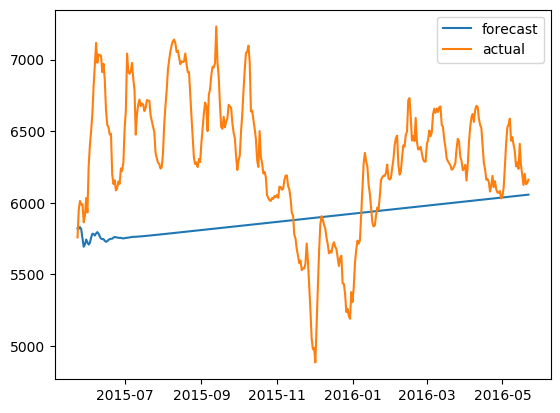

In [13]:
import matplotlib.pyplot as plt

plt.plot(df_results.index, df_results["store_sales_forecast"], label = "forecast")
plt.plot(df_test.index, df_test["store_sales"], label = "actual")
plt.legend()
plt.show()


No handles with labels found to put in legend.


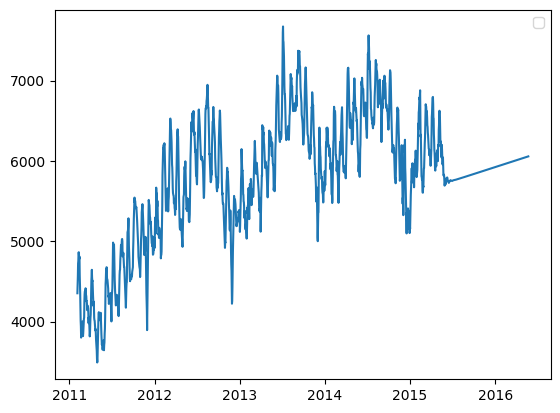

In [19]:
df_org_sales = df_orginal["store_sales"][0:-nobs]
df_org_sales = df_org_sales.append(df_results["store_sales_forecast"])

plt.plot(df_org_sales.index, df_org_sales)
plt.legend()
plt.show()